<a href="https://colab.research.google.com/github/anash963/Practice_Notebooks/blob/main/Feb_14_Sarcasm_Classifier_Using_NLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow as tf

In [66]:
df = pd.read_csv("/content/sample_data/wine-reviews.csv")

In [67]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [68]:
#using the columns we need

df = pd.read_csv("/content/sample_data/wine-reviews.csv",usecols=["country", "description", "points", "price", "variety", "winery"])

In [69]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [70]:
df = df.dropna(subset=['description', 'points'])

In [71]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


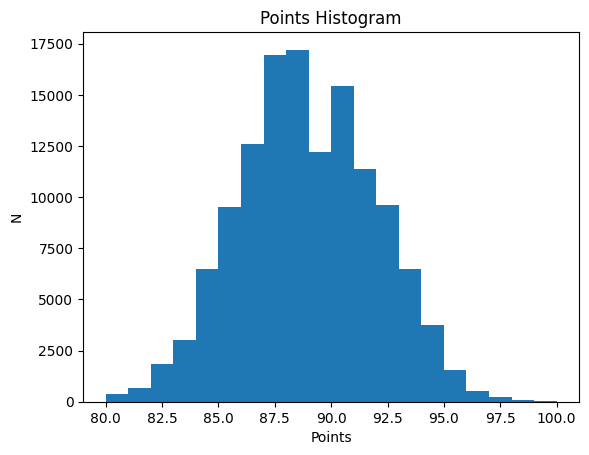

In [72]:
plt.hist(df['points'], bins=20)
plt.title('Points Histogram')
plt.xlabel('Points')
plt.ylabel('N')
plt.show()

In [73]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

In [74]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [75]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [76]:
#modified function from tensorflow site

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [77]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [78]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'The 16th-century chateau of Saint Lager is on the slopes of the local landmark hill of Brouilly. The wine comes from vines below. It has spice, cherry and blueberry fruits with attractive acidity. The wine, still with a strong tannic edge, will be better from 2017.',
        b'This inky black blend of Cabernet Sauvignon and Merlot delivers a thick, impenetrable appearance with jammy notes of blackberry preserves and maraschino cherry. It presents chewy, succulent fruit but is not overdone or too heavy on the close.',
        b"Good price for a wine this rich and pleasing. With masses of blackberries, cherries, currants, anise and cedar folded into firm tannins, it's ready to drink now. Just might be the best value you'll find in a Spring Mountain wine, red or white.",
        ...,
        b'This hearty red opens with aromas of leafy underbrush, leather, licorice and a hint of menthol. The firm, chewy palate offers ripe wild che

## Embedding+Model

In [79]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [80]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.19763362, -0.1277637 , -0.17549798, ...,  0.02590632,
        -0.15879978,  0.06026058],
       [ 0.41512334, -0.03979946,  0.12322029, ...,  0.07870907,
        -0.4304062 ,  0.00898439],
       [ 0.36430055, -0.02622948,  0.10717919, ...,  0.11081056,
        -0.04108225,  0.12937416],
       ...,
       [ 0.39837214, -0.2807372 , -0.00583045, ..., -0.0577668 ,
        -0.07747348,  0.07096401],
       [ 0.31850824, -0.09130048,  0.20140989, ..., -0.05164846,
        -0.09091274,  0.03846334],
       [ 0.52799493, -0.39672425,  0.01345862, ...,  0.03452944,
        -0.35500655, -0.11945733]], dtype=float32)>

In [82]:
print(type(hub_layer))

<class 'tensorflow_hub.keras_layer.KerasLayer'>


In [83]:
model = tf.keras.Sequential()
#model.add(hub_layer)
model.add(tf.keras.layers.Lambda(lambda x: hub_layer(x)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [84]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [85]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4524 - loss: 0.6969


[0.6968582272529602, 0.4537489414215088]

In [86]:
model.evaluate(val_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4476 - loss: 0.6969


[0.6967151761054993, 0.45248904824256897]

In [87]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5688 - loss: 0.6797 - val_accuracy: 0.6208 - val_loss: 0.6417
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6316 - loss: 0.6451 - val_accuracy: 0.6451 - val_loss: 0.6178
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6445 - loss: 0.6274 - val_accuracy: 0.6712 - val_loss: 0.6026
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6536 - loss: 0.6161 - val_accuracy: 0.6831 - val_loss: 0.5940
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6616 - loss: 0.6085 - val_accuracy: 0.6918 - val_loss: 0.5890
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6695 - loss: 0.6021 - val_accuracy: 0.6984 - val_loss: 0.5828
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6753 - loss: 0.5998 - val_accuracy: 0.7005 - val_loss: 0.5797
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6815 - loss: 0.5943 - val_accu

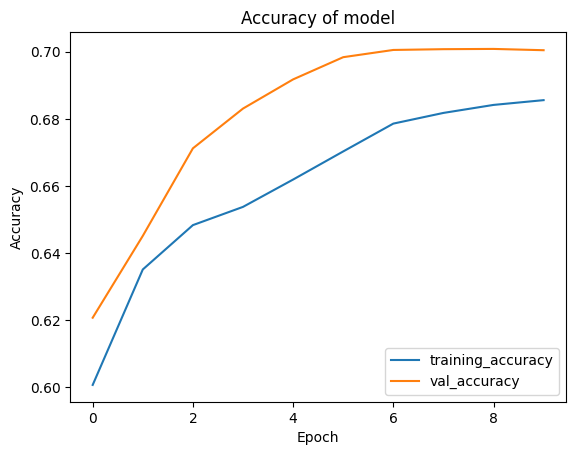

In [92]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("Accuracy of model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

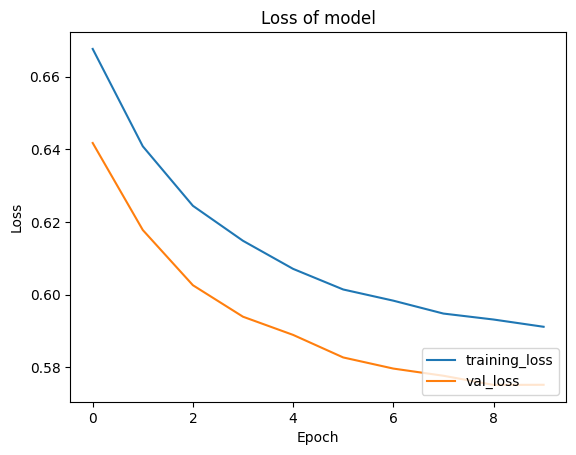

In [93]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title("Loss of model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower right")

In [94]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6981 - loss: 0.5774


[0.576848030090332, 0.7010309100151062]

## LSTM

In [96]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [98]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [99]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [105]:
model.evaluate(train_data)
model.evaluate(val_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.4627 - loss: 0.6934
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.4693 - loss: 0.6934


[0.6934003233909607, 0.4717242419719696]

In [106]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 527ms/step - accuracy: 0.6653 - loss: 0.5988 - val_accuracy: 0.8279 - val_loss: 0.3754
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 54s 522ms/step - accuracy: 0.8384 - loss: 0.3589 - val_accuracy: 0.8330 - val_loss: 0.3551
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 514ms/step - accuracy: 0.8452 - loss: 0.3423 - val_accuracy: 0.8374 - val_loss: 0.3612
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 543ms/step - accuracy: 0.8494 - loss: 0.3320 - val_accuracy: 0.8361 - val_loss: 0.3647
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 528ms/step - accuracy: 0.8499 - loss: 0.3313 - val_accuracy: 0.8395 - val_loss: 0.3513


In [ ]:
model.evaluate(test_data)